# EXERCÍCIO 5: SELEÇÃO DE MODELOS E REGULARIZAÇÃO

### Comparando coeficiente R²

Primeiro comparamos o coeficiente R2 obtido através de regressão linear múltipla, Lasso e ridge regression, todos aplicados em um mesmo dataset. Aproveitando que já estamos realizando a comparação, fazemos gráficos $\alpha$ X R² para os métodos Lasso e ridge regression.

R² Linear Múltipla: 0.6846
R² Lasso (grau 2): 0.7594
R² Ridge: 0.6756


/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e+03, tolerance: 3.153e+00
  model = cd_fast.enet_coordinate_descent(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.585e+02, tolerance: 3.153e+00
  model = cd_fast.enet_coordinate_descent(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

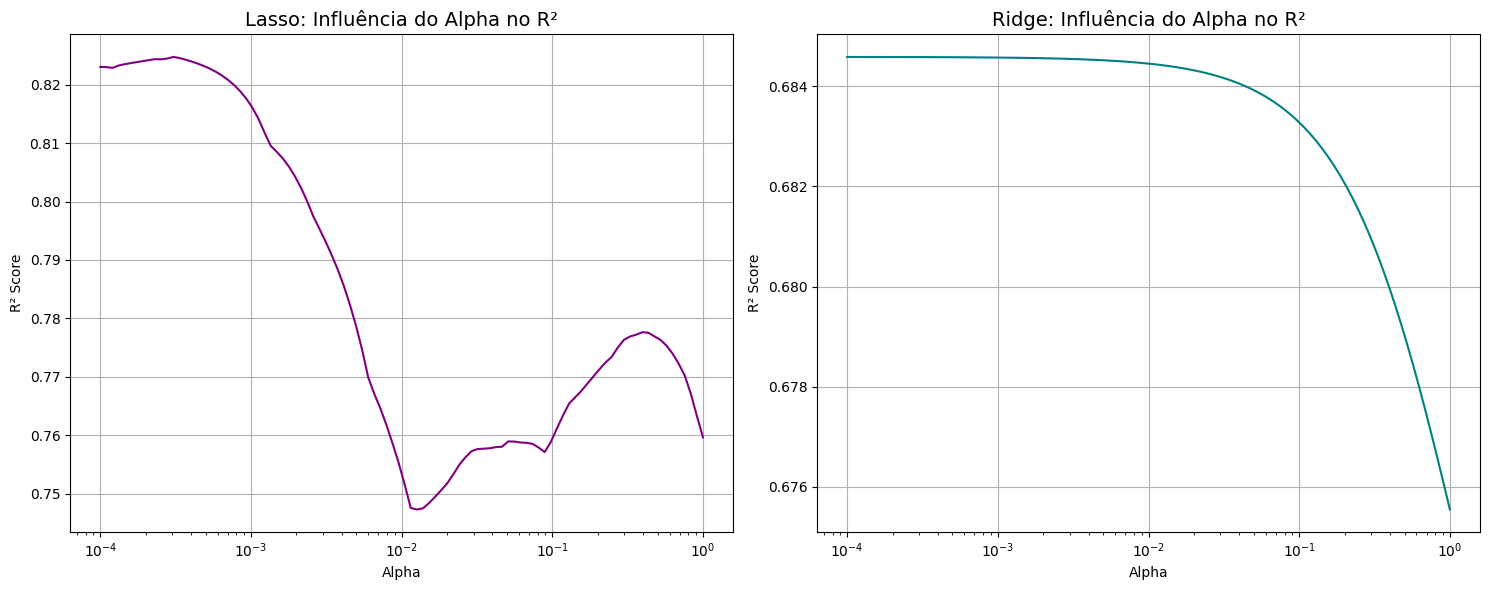

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.preprocessing import PolynomialFeatures 

# Configuração inicial e carregamento dos dados
np.random.seed(33)
data = pd.read_csv('data/BostonHousing.csv')

# Preparação dos dados
data = data.to_numpy() 
y = data[:,-1]
X = data[:,0:-1]

# Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=33)

# 1 - Regressão Linear Múltipla
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
lm_y_pred = lm.predict(X_test)
lm_R2 = r2_score(y_test, lm_y_pred)
print(f'R² Linear Múltipla: {lm_R2:.4f}')

# 2 - Lasso com Features Polinomiais
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

lasso_model = linear_model.Lasso(alpha=0.1, max_iter=10000)
lasso_model.fit(X_train_poly, y_train)
lasso_y_pred = lasso_model.predict(X_test_poly)
lasso_R2 = r2_score(y_test, lasso_y_pred)
print(f'R² Lasso (grau 2): {lasso_R2:.4f}')

# 3 - Ridge Regression
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_y_pred = ridge.predict(X_test)

ridge_R2 = r2_score(y_test, ridge_y_pred)
print(f'R² Ridge: {ridge_R2:.4f}')

### GRÁFICOS ###

# Gráfico para o Lasso
# Define uma lista de valores de alpha para testar
alphas = np.logspace(-4, 0, 100)
lasso_r2_scores = []

# Reutiliza as features polinomiais já calculadas anteriormente
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Itera sobre cada alpha, treina o modelo e guarda o R²
for alpha in alphas:
    model = linear_model.Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    lasso_r2_scores.append(r2_score(y_test, y_pred))

# 2.  Gráfico Ridge
ridge_r2_scores = []

# Itera sobre cada alpha, treina o modelo e guarda o R²
for alpha in alphas:
    model = linear_model.Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ridge_r2_scores.append(r2_score(y_test, y_pred))

# 3. Plotagem dos Gráficos
# Cria uma figura com dois subplots, um ao lado do outro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico para Lasso
ax1.plot(alphas, lasso_r2_scores, color='purple')
ax1.set_xscale('log') # A escala logarítmica ajuda a visualizar melhor os alphas pequenos
ax1.set_title('Lasso: Influência do Alpha no R²', fontsize=14)
ax1.set_xlabel('Alpha')
ax1.set_ylabel('R² Score')
ax1.grid(True)

# Gráfico para Ridge
ax2.plot(alphas, ridge_r2_scores, color='teal')
ax2.set_xscale('log')
ax2.set_title('Ridge: Influência do Alpha no R²', fontsize=14)
ax2.set_xlabel('Alpha')
ax2.set_ylabel('R² Score')
ax2.grid(True)

plt.tight_layout() # Ajusta o espaçamento para que os títulos não se sobreponham
plt.show()

### Determinando variávei de maior importância usando Lasso

Utilizando da mesma base de dados, encontramos, novamente por meio de uso de Lasso, a variável de maior importância (usando model.coef_)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# Configuração inicial e carregamento dos dados
np.random.seed(33)
data = pd.read_csv('data/BostonHousing.csv')

# Guarda os nomes das colunas originais para referência futura
original = data.columns[:-1]

# Preparação dos dados
y = data.iloc[:, -1].values
X = data.iloc[:, 0:-1].values

# Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=42)

# --- Modelo Lasso com Análise de Coeficientes ---

# 1. Criação de Features Polinomiais (grau 2)
# Isso cria interações entre as variáveis (ex: 'LSTAT' * 'RM') e termos quadráticos (ex: 'LSTAT'^2)
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# 2. Treinamento do Modelo Lasso
# Um alpha de 0.1 é um bom ponto de partida para forçar alguns coeficientes a zero
lasso_model = Lasso(alpha=0.1, max_iter=10000)
lasso_model.fit(X_train_poly, y_train)

# 3. Análise dos Coeficientes (model.coef_)
# Recupera os nomes de todas as features polinomiais geradas
poly_feature_names = poly_features.get_feature_names_out(original)

# Cria um DataFrame para visualizar os coeficientes e seus nomes
df_coeficientes = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coeficiente': lasso_model.coef_
})

# Calcula o valor absoluto para ordenar pela importância (magnitude)
df_coeficientes['Coeficiente_Absoluto'] = df_coeficientes['Coeficiente'].abs()

# Filtra apenas os coeficientes que o Lasso NÃO zerou
df_importantes = df_coeficientes[df_coeficientes['Coeficiente'] != 0].copy()

# Ordena pela magnitude do coeficiente para ver os mais importantes no topo
df_importantes_sorted = df_importantes.sort_values('Coeficiente_Absoluto', ascending=False)


# 4. Exibição dos Resultados
print("--- Análise do Modelo Lasso ---")
lasso_y_pred = lasso_model.predict(X_test_poly)
lasso_R2 = r2_score(y_test, lasso_y_pred)
print(f'R² Lasso (grau 2): {lasso_R2:.4f}\n')

print(f"Total de features polinomiais geradas: {len(df_coeficientes)}")
print(f"Features selecionadas pelo Lasso (coeficiente != 0): {len(df_importantes)}\n")

print("--- Variáveis de Maior Importância Segundo o Modelo Lasso ---")
# Exibe as 10 features mais importantes
print(df_importantes_sorted.head(10).to_string(index=False))

--- Análise do Modelo Lasso ---
R² Lasso (grau 2): 0.7802

Total de features polinomiais geradas: 104
Features selecionadas pelo Lasso (coeficiente != 0): 74

--- Variáveis de Maior Importância Segundo o Modelo Lasso ---
    Feature  Coeficiente  Coeficiente_Absoluto
  crim chas     2.163583              2.163583
       rm^2     1.075387              1.075387
     rm rad    -0.414859              0.414859
      dis^2     0.304161              0.304161
    crim rm     0.245278              0.245278
 chas lstat    -0.225117              0.225117
          b     0.203524              0.203524
      rad^2    -0.138219              0.138219
rad ptratio     0.117855              0.117855
        age     0.116112              0.116112


/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e+03, tolerance: 2.933e+00
  model = cd_fast.enet_coordinate_descent(


### Testando a Regularização

Buscamos o melhor grau de polinômio para se adequar a reta

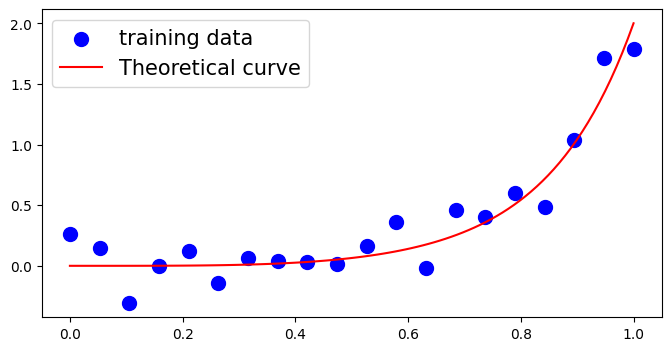

Analisando o melhor grau de polinômio com Lasso (grau máximo testado: 15)
----------------------------------------------------------------------

Resultados para alpha = 0.0001:
  Graus com coeficientes não-nulos: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 15]
  O maior grau significativo encontrado foi: 15

Resultados para alpha = 0.001:
  Graus com coeficientes não-nulos: [1, 2, 7, 8, 9, 15]
  O maior grau significativo encontrado foi: 15

Resultados para alpha = 0.01:
  Graus com coeficientes não-nulos: [4, 5, 6, 7, 8, 9]
  O maior grau significativo encontrado foi: 9

Resultados para alpha = 0.1:
  Graus com coeficientes não-nulos: [5, 6]
  O maior grau significativo encontrado foi: 6

Resultados para alpha = 1:
 Todos os coeficientes foram zerados. A regularização foi muito forte.


/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-02, tolerance: 5.943e-03
  model = cd_fast.enet_coordinate_descent(


In [8]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(10)

#função para gerar os dados
def function(x):
    y = x**4 + x**9
    return y

# training set
N_train = 20
sigma = 0.2
x_train= np.linspace(0, 1,N_train)
y_train = function(x_train) + np.random.normal(0,sigma, N_train)
x_train = x_train.reshape(len(x_train), 1)
fig = plt.figure(figsize=(8, 4))
plt.scatter(x_train, y_train, facecolor="blue", edgecolor="b", s=100, label="training data")

# test set
N_test = 20
x_test=np.linspace(0, 1,N_test)
y_test = function(x_test) + np.random.normal(0,sigma, N_test)
x_test = x_test.reshape(len(x_test), 1)

# Curva teorica
xt = np.linspace(0,1,100)
yt = function(xt)
plt.plot(xt,yt, '-r', label="Theoretical curve")
plt.legend(fontsize=15)
plt.show(True)

# Usando Lasso para aproximar
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

# Definimos um grau máximo para testar (um valor alto de propósito para causar overfitting, já que o método Lasso irá se auto corrigir)
grau_maximo = 15


alphas_para_testar = [1e-4, 1e-3, 1e-2, 1e-1, 1]

print(f"Analisando o melhor grau de polinômio com Lasso (grau máximo testado: {grau_maximo})")
print("-" * 70)

# Iteramos sobre cada valor de alpha
for alpha in alphas_para_testar:
    model = make_pipeline(
        PolynomialFeatures(degree=grau_maximo, include_bias=False),
        StandardScaler(),
        Lasso(alpha=alpha, max_iter=10000, tol=1e-3)
    )
    
    # Treinamos o modelo com os dados de treino gerados pelo seu código
    model.fit(x_train, y_train)
    
    # Extraímos os coeficientes que o modelo Lasso aprendeu
    coeficientes = model.named_steps['lasso'].coef_
    
    # Identificamos quais graus (potências de x) tiveram coeficientes diferentes de zero
    # Adicionamos +1 ao índice porque o primeiro coeficiente (índice 0) corresponde a x^1
    graus_selecionados = [i + 1 for i, coef in enumerate(coeficientes) if abs(coef) > 1e-4]
    
    print(f"\nResultados para alpha = {alpha}:")
    if not graus_selecionados:
        print(" Todos os coeficientes foram zerados. A regularização foi muito forte.")
    else:
        print(f"  Graus com coeficientes não-nulos: {graus_selecionados}")
        print(f"  O maior grau significativo encontrado foi: {max(graus_selecionados)}")

### Comparando Knn e Regressão Logística



In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Carregamento e preparação dos dados
np.random.seed(33)
data = pd.read_csv('data/Vehicle.csv')

y = data.iloc[:, -1].values
X = data.iloc[:, 0:-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=33)

# Escalonamento dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Otimização para Regressão Logística ---
print("Iniciando busca por hiperparâmetros para Regressão Logística...")
params_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=33),
    params_lr,
    cv=5,
    n_jobs=-1
)
grid_search_lr.fit(X_train_scaled, y_train)

print("\nResultados da Regressão Logística:")
print(f"Melhor acurácia (CV): {grid_search_lr.best_score_:.4f}")
print(f"Melhores hiperparâmetros: {grid_search_lr.best_params_}")
print("-" * 50)

# --- Otimização para KNN ---
print("\nIniciando busca por hiperparâmetros para KNN...")
params_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    params_knn,
    cv=5,
    n_jobs=-1
)
grid_search_knn.fit(X_train_scaled, y_train)

print("\nResultados do KNN:")
print(f"Melhor acurácia (CV): {grid_search_knn.best_score_:.4f}")
print(f"Melhores hiperparâmetros: {grid_search_knn.best_params_}")
print("-" * 50)

# --- Avaliação Final do Melhor Modelo no Conjunto de Teste ---
print("\n--- Avaliação Final ---")

if grid_search_lr.best_score_ > grid_search_knn.best_score_:
    print("Modelo escolhido: Regressão Logística")
    best_model = grid_search_lr.best_estimator_
else:
    print("Modelo escolhido: KNN")
    best_model = grid_search_knn.best_estimator_

y_pred = best_model.predict(X_test_scaled)

print(f"\nAcurácia final no conjunto de teste: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))



Iniciando busca por hiperparâmetros para Regressão Logística...


/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver whi


Resultados da Regressão Logística:
Melhor acurácia (CV): 0.8006
Melhores hiperparâmetros: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
--------------------------------------------------

Iniciando busca por hiperparâmetros para KNN...


/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/antonio/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 492, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/antonio/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 446, in score
    return super().score(X, y, sample_weight)
  File "/home/antonio/.local/lib/python3.10/site-packages/sklearn/base.py", line 548, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/antonio/.local/lib/python3.10/site-packages/sklearn/neighbors/_classifi


Resultados do KNN:
Melhor acurácia (CV): 0.7145
Melhores hiperparâmetros: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
--------------------------------------------------

--- Avaliação Final ---
Modelo escolhido: Regressão Logística

Acurácia final no conjunto de teste: 0.8110

Relatório de Classificação:
              precision    recall  f1-score   support

         bus       0.94      0.96      0.95        69
        opel       0.65      0.68      0.66        59
        saab       0.69      0.63      0.66        67
         van       0.95      0.98      0.97        59

    accuracy                           0.81       254
   macro avg       0.81      0.81      0.81       254
weighted avg       0.81      0.81      0.81       254



/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.70431562 0.70937188 0.69253668 0.69759294 0.67902008 0.68914685
 0.68742344 0.69588378 0.67225466 0.68068651        nan 0.69934482
        nan 0.70267768        nan 0.71448512        nan 0.71442814
        nan 0.7077197  0.70431562 0.70937188 0.69253668 0.69759294
 0.67902008 0.68914685 0.68742344 0.69588378 0.67225466 0.68068651]
  warnings.warn(


### Analisando correlação

Agora adotando um novo dataset, fazemos uma análise de correlação entre seus dados.

Arquivo carregado com sucesso. Visualização dos dados:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.

/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=11.
  warnings.warn(


11         | 0.5899               | 0.0682              
12         | 0.5867               | 0.0670              
13         | 0.5960               | 0.0684              


/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=12.
  warnings.warn(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=13.
  warnings.warn(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=14.
  warnings.warn(


14         | 0.5911               | 0.0662              
15         | 0.5929               | 0.0753              


/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=15.
  warnings.warn(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=16.
  warnings.warn(


16         | 0.5960               | 0.0814              
17         | 0.5898               | 0.0797              


/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=17.
  warnings.warn(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=18.
  warnings.warn(


18         | 0.5948               | 0.0834              
19         | 0.5980               | 0.0810              


/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=19.
  warnings.warn(
/home/antonio/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=20.
  warnings.warn(


20         | 0.5916               | 0.0818              


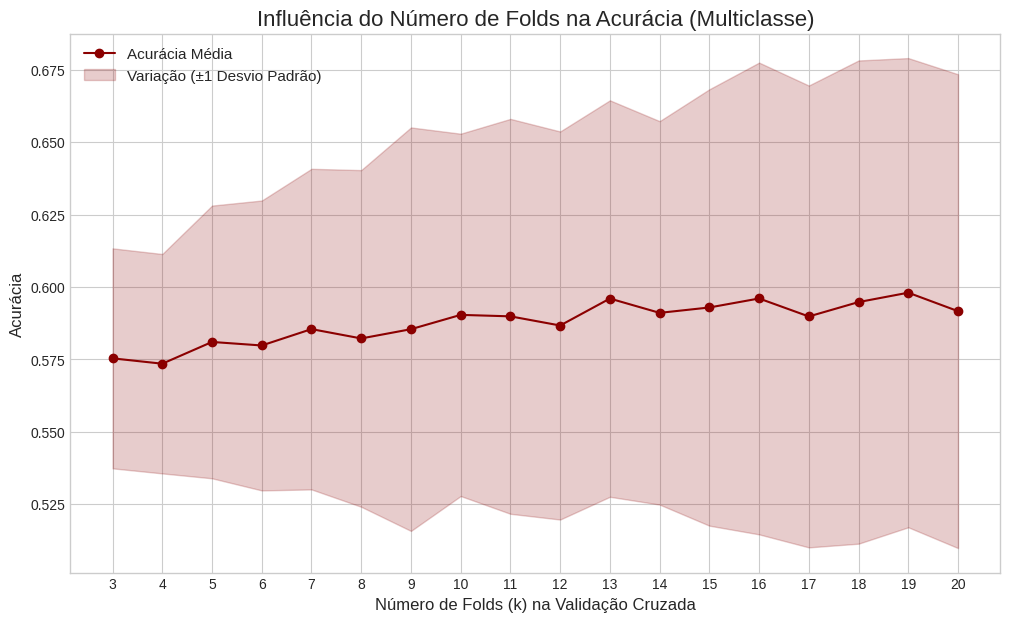

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Carregamento e Preparação dos Dados
np.random.seed(33)

try:
    # CORREÇÃO: Removido o 'sep=';' para usar o separador padrão (vírgula)
    data = pd.read_csv('data/winequality-red.csv')
    print("Arquivo carregado com sucesso. Visualização dos dados:")
    print(data.head())
    print("-" * 60)
except FileNotFoundError:
    print("Erro: Arquivo 'winequality-red.csv' não encontrado.")
    exit()

# A coluna 'quality' é o nosso alvo (y)
y = data['quality'].values
# Todas as outras colunas são as nossas features (X)
X = data.drop('quality', axis=1).values

# Escalonamento dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Testando a Influência do Número de Folds
model = LogisticRegression(max_iter=2000, random_state=33)

fold_numbers = range(3, 21)
mean_accuracies = []
std_devs = []

print("Executando validação cruzada para diferentes números de folds...")
print(f"{'Folds':<10} | {'Acurácia Média':<20} | {'Desvio Padrão':<20}")
print("-" * 60)

for k in fold_numbers:
    scores = cross_val_score(model, X_scaled, y, cv=k, scoring='accuracy', n_jobs=-1)
    mean_accuracies.append(scores.mean())
    std_devs.append(scores.std())
    print(f"{k:<10} | {scores.mean():<20.4f} | {scores.std():<20.4f}")

# 3. Visualização dos Resultados
mean_accuracies = np.array(mean_accuracies)
std_devs = np.array(std_devs)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(fold_numbers, mean_accuracies, 'o-', color='darkred', label='Acurácia Média')
ax.fill_between(
    fold_numbers,
    mean_accuracies - std_devs,
    mean_accuracies + std_devs,
    color='darkred',
    alpha=0.2,
    label='Variação (±1 Desvio Padrão)'
)

ax.set_title('Influência do Número de Folds na Acurácia (Multiclasse)', fontsize=16)
ax.set_xlabel('Número de Folds (k) na Validação Cruzada', fontsize=12)
ax.set_ylabel('Acurácia', fontsize=12)
ax.set_xticks(fold_numbers)
ax.legend(fontsize=11)
plt.show()